In [1]:
import os
import sys
sys.path.append("../StyleCLIP_modular")
from style_clip import Imagine, create_text_path

In [2]:
args = dict()
args["model_type"] = "stylegan"

prefix_sg3_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"
#args["style"] = prefix_sg3_pkl + "stylegan3-t-ffhq-1024x1024.pkl"
args["style"] = prefix_sg3_pkl + "stylegan3-t-metfaces-1024x1024.pkl"
#"../stylegan3/sg3_madziowa_p_240.pkl"
# met data

#sg2                         
#args["style"] = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl"

prime_steps = 5000
# sg3 all layers
args["opt_all_layers"] = 1
args["extend_sizes"] = 0.0
args["noise_opt"] = 0
args["opt_extra"] = 0
#args["sideX"] = 480
#args["sideY"] = 270
args["iterations"] = 1000
args["clip_names"] = ["ViT-B/16", "ViT-B/32"]
args["batch_size"] = 24
args["lr"] = 0.003
args["lr_schedule"] = 0

imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                verbose=False,
                **args
               )

Setting up PyTorch plugin "bias_act_plugin"... Done.
Latent shape:  torch.Size([1, 16, 512])


In [3]:
angel_imgs = ["base_images/angels/ben_moran_angel_face.png",
              "base_images/angels/benmoran_angel_of_wings.jpg",
              "base_images/angels/gold_angel_janedalford.png",
              "base_images/angels/naomi_baker_wings.jpg",
              "base_images/angels/silence_dorina_costras.jpg"
             ]
angel_prompts = ["The face of a beautiful angel",
                "A beautiful angel",
                "A beautiful angel is looking directly at you",
                "A golden angel",
                "A red angel", 
                "An angel. By Picasso",
                "An angel. By James Gurney.",
                "A painting of an angel",
                "A painting of the face of an angel"]

In [4]:
import matplotlib.pyplot as plt
import torchvision
from IPython.display import display, clear_output
from tqdm.auto import tqdm

to_pil = torchvision.transforms.ToPILImage()


def create_latents(imagine, its=30, verbose=False):
    latents = []
    losses = []
    pbar = tqdm(range(its))
    for i in pbar:
        img, loss = imagine.train_step(0, 0)

        if verbose and i % 2 == 0:
            pil_img = to_pil(img.cpu().squeeze(0))

            clear_output(wait = True)
            #display(pil_img)

            plt.imshow(pil_img)
            plt.axis("off")
            plt.show()
        loss = loss.item()
        losses.append(loss)
        latents.append(imagine.get_latent().clone())
        pbar.set_description("Loss: " + str(round(loss, 2)))
    return latents, losses

In [5]:
import torch

def show_img(img):
    pil_img = to_pil(img.cpu().squeeze(0))
    plt.imshow(pil_img)
    plt.axis("off")
    plt.show()

@torch.inference_mode()
def show_latent(imagine, latent):
    img = imagine.model.model(latents=latent.to(imagine.device))
    show_img(img)

In [6]:
#imagine

In [7]:
imagine.model.model.extend_sizes = 0.0

In [8]:
from style_clip.model import make_affine_transform
import numpy as np
from PIL import Image

def get_lat(imagine, bufs=False, return_extra=False):
    if args["noise_opt"]:
        latents = imagine.get_latent()
        lat, noise_bufs = latents
        lat = lat.clone()
        if bufs:
            return lat, noise_bufs
    elif args["opt_extra"]:
        lat, extra = imagine.get_latent()
        lat = lat.clone()
        #for vec in extra:
        #    print(vec.shape)
        #print()
        if return_extra:
            return lat, extra
    else:
        lat = imagine.get_latent().clone()
    return lat
        

def get_new_keyframe(imagine, img=None, text=None, its=100):
    if text is not None:
        print(text)
    if img is not None:
        pil_img = Image.open(img).convert("RGB")
        import torchvision.transforms as T
        image_width = 224
        t = T.Compose([T.Resize(image_width),
                       T.CenterCrop((image_width, image_width))]
                     )
        pil_img = t(pil_img)
        plt.imshow(pil_img)
        plt.axis("off")
        plt.show()
        
    
    imagine.set_clip_encoding(img=img, text=text)
    new_latents, losses = create_latents(imagine, its=its, verbose=False)
    best_latent_idx = np.argmin(losses)
    best_latent = new_latents[best_latent_idx]
    plt.plot(losses)
    plt.show()
    print("Best latent idx: ", best_latent_idx)
    print("After latent opt")
    #show_latent(imagine, new_latents[-1])
    show_latent(imagine, best_latent)
    imagine.set_latent(best_latent)
    return best_latent


def lpips_opt(imagine, start_image, steps=1000):
    import lpips
    target_img = torch.nn.functional.interpolate(start_image, size=(1024, 1024), mode="bilinear", align_corners=False)
    loss_fn = lpips.LPIPS(net='vgg').to("cuda") # "alex"
    
    optimizer = torch.optim.Adam(list(imagine.model.model.parameters()), 
                                 lr=0.1,)
                                 #betas=(0.9, 0.999))
    #scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.05, max_lr=0.5, step_size_up = steps // 10,  mode = "triangular",#, triangular2, exp_range}.))
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps, eta_min=0)
    from style_clip.style_clip import MakeCutoutsRHW
    
    t = MakeCutoutsRHW(224)
    bs = 16
    
    lpips_losses = []
    lrs = []
    print(target_img.shape)
    pbar = tqdm(range(steps))
    for s in pbar:
        # calc loss
        img = imagine.model.model()
        stacked = torch.cat([img, target_img], dim=1)
        augmented = torch.cat([t(stacked) for _ in range(bs)])
        # shape: [bs, 6, size, size] size=224
        aug_img = augmented[:, 0:3]
        aug_target_img = augmented[:, 3:]
        losses = loss_fn.forward(aug_img, aug_target_img, normalize=True)
        loss = losses.mean()
        # opt
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        lr = scheduler.get_last_lr()
        lrs.append(lr)
        # debugging
        loss = round(loss.item(), 3)
        lpips_losses.append(loss)
        pbar.set_description("Loss: " + str(loss))
        if s % (steps // 10) == 0:
            if args["opt_extra"]:
                print(imagine.model.model.model.synthesis.input.weight.mean())
                print(imagine.model.model.model.synthesis.input.weight.std())
            show_img(img.detach())
            print(loss)
            
    plt.figure()
    plt.plot(lpips_losses)
    plt.show()
    plt.figure()
    plt.plot(lrs)
    plt.show()
    prime_latent = get_lat(imagine)
    return prime_latent


def add_new_keyframe(imagine, keyframes, *args, style=None, reset=True, **kwargs):
    if reset:
        imagine.reset()
    db_name = "latent_clip_db"
    name = f"{kwargs['img'] if 'img' in kwargs else ''}_{kwargs['text'] if 'text' in kwargs else ''}_{style.split('/')[-1]}_{kwargs['its']}"
    
    keyframe = get_from_db(db_name, name)
    if keyframe is None:
        keyframe = get_new_keyframe(imagine, *args, **kwargs)
        add_to_db(keyframe, db_name, name)
    imagine.set_latent(keyframe)
    keyframes.append(keyframe)


def add_to_db(latent, db_name, latent_name):
    # setup "database"
    db_name += ".pt"
    if not os.path.exists(db_name):
        db = {}
    else:
        db = torch.load(db_name)
    db[latent_name] = latent.cpu()
    torch.save(db, db_name)


def get_from_db(db_name, latent_name):
    db_name += ".pt"
    if not os.path.exists(db_name):
        return None
    else:
        db = torch.load(db_name)
        if latent_name in db:
            return db[latent_name]
        else:
            return None

In [9]:
# paths
folder = "base_images/seyhanlee/"
all_imgs = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
all_paths = [os.path.join(folder, i) for i in all_imgs]
joni_paths = [p for p in all_paths if "joni" in p]
angel_paths = [p for p in all_paths if "joni" not in p]
#print(joni_paths)
female_angel_folder = "base_images/angel_faces/female"
male_angel_folder = "base_images/angel_faces/male"
female_angel_paths = [os.path.join(female_angel_folder, i) for i in os.listdir(female_angel_folder) if i.endswith(".jpg") or i.endswith(".png") or i.endswith(".jpeg")]
male_angel_paths = [os.path.join(male_angel_folder, i) for i in os.listdir(male_angel_folder) if i.endswith(".jpg") or i.endswith(".png") or i.endswith(".jpeg")]
print("Num female angel imgs: ", len(female_angel_paths))
print("Num male angel imgs: ", len(male_angel_paths))

Num female angel imgs:  28
Num male angel imgs:  4


Latent shape:  torch.Size([1, 16, 512])
torch.Size([1, 16, 512])
Start image
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


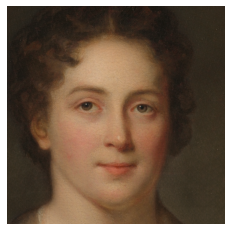

Latent shape:  torch.Size([1, 16, 512])


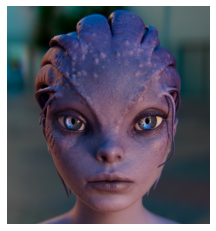

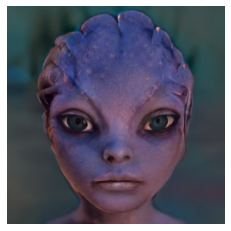

Latent shape:  torch.Size([1, 16, 512])


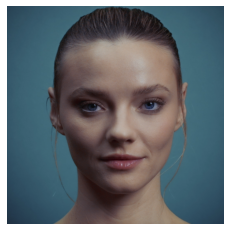

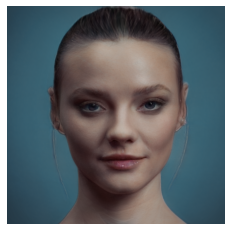

Latent shape:  torch.Size([1, 16, 512])


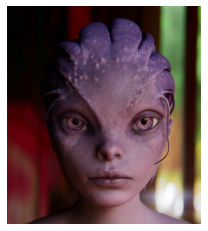

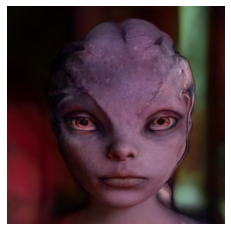

Latent shape:  torch.Size([1, 16, 512])


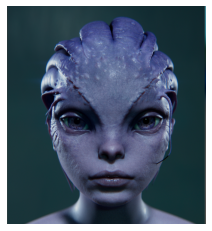

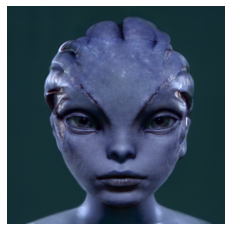

Latent shape:  torch.Size([1, 16, 512])


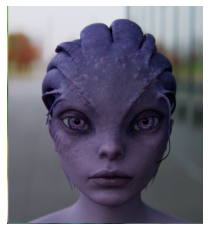

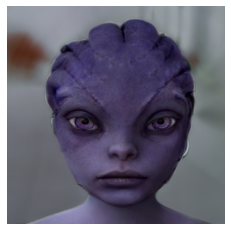

Latent shape:  torch.Size([1, 16, 512])


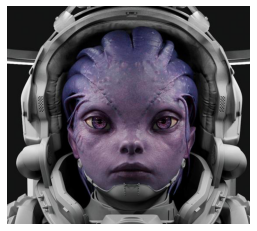

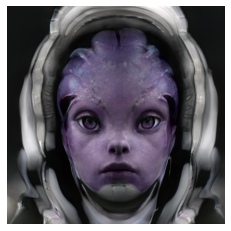

Latent shape:  torch.Size([1, 16, 512])


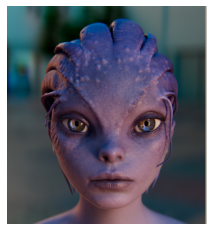

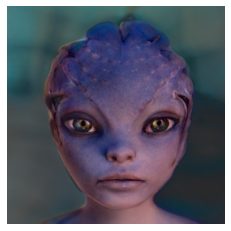

Latent shape:  torch.Size([1, 16, 512])
An awesome alien


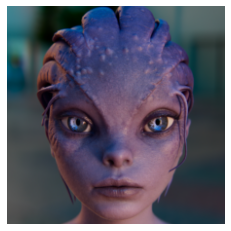

  0%|          | 0/1000 [00:00<?, ?it/s]

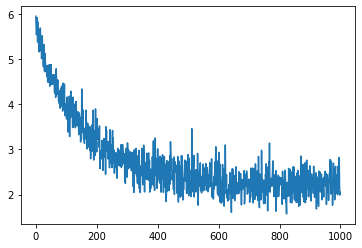

Best latent idx:  823
After latent opt


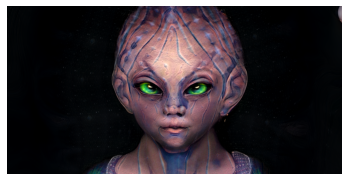

NEW PROMPTS
Latent shape:  torch.Size([1, 16, 512])
An awesome angel


  0%|          | 0/1000 [00:00<?, ?it/s]

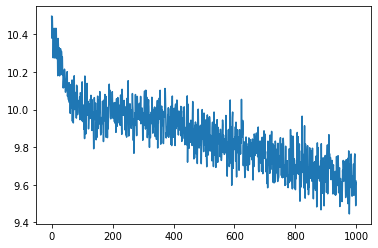

Best latent idx:  977
After latent opt


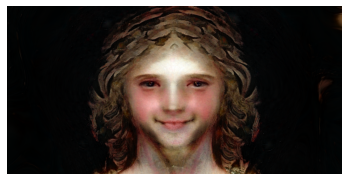

Latent shape:  torch.Size([1, 16, 512])
An astonishing, wondrous angel


  0%|          | 0/1000 [00:00<?, ?it/s]

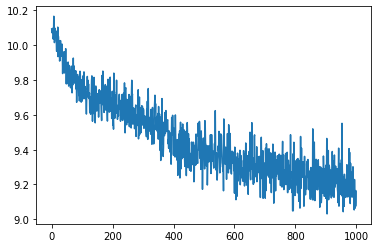

Best latent idx:  904
After latent opt


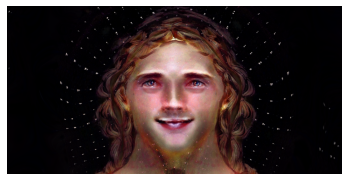

Latent shape:  torch.Size([1, 16, 512])
A psychedelic angel


  0%|          | 0/1000 [00:00<?, ?it/s]

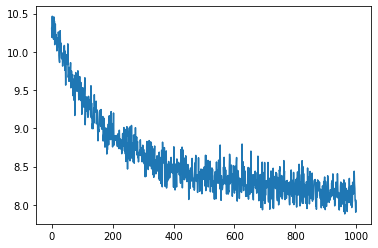

Best latent idx:  962
After latent opt


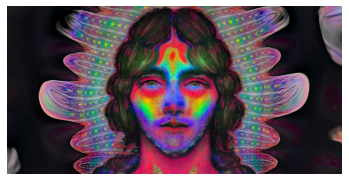

Latent shape:  torch.Size([1, 16, 512])
An alien-looking angel


  0%|          | 0/1000 [00:00<?, ?it/s]

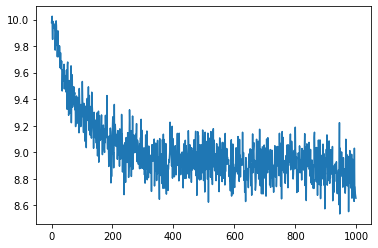

Best latent idx:  946
After latent opt


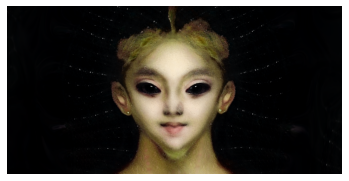

Latent shape:  torch.Size([1, 16, 512])
A sacred angel


  0%|          | 0/1000 [00:00<?, ?it/s]

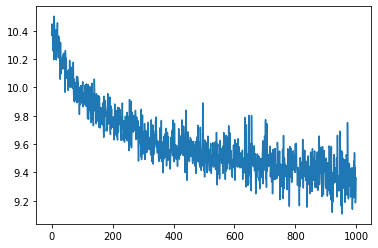

Best latent idx:  953
After latent opt


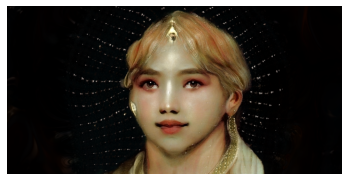

Latent shape:  torch.Size([1, 16, 512])
A sacred alien


  0%|          | 0/1000 [00:00<?, ?it/s]

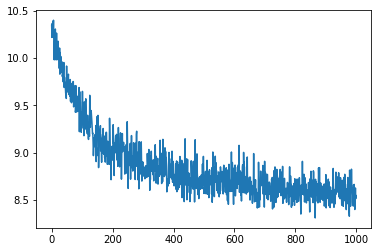

Best latent idx:  865
After latent opt


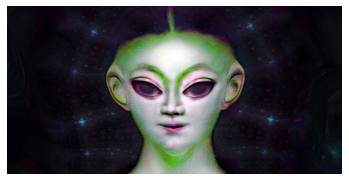

Latent shape:  torch.Size([1, 16, 512])
An awesome alien


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# 1. Joni transforming into the Model 
# 2. Joni transforming into angels and into our model 
# 3. Angels transitioning into our model
# 4. NVIDIA paintings transitioning into angels (we’ll crop the paintings later)

imagine.reset()

start_latent = get_lat(imagine)
print(start_latent.shape)

print("Start image")
show_latent(imagine, start_latent)
keyframes = [start_latent]

# prime start image
orig_extend = imagine.model.model.extend_sizes
imagine.model.model.extend_sizes = 0.0
imagine.start_image_steps = prime_steps

prime = True
use_lpips = True

if use_lpips:
    """
    from style_clip.utils import open_url
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to("cuda")
    for param in vgg16.parameters():
        param.requires_grad = False
    """
    def add_priming(prime_path, prime_steps):
        start_image = torchvision.transforms.ToTensor()(Image.open(prime_path).convert("RGB")).unsqueeze(0).to(imagine.device)
        show_img(start_image.cpu())

        db_name = "priming_db"
        save_name = prime_path + "_" + str(prime_steps)
        prime_latent = get_from_db(db_name, save_name)
        if prime_latent is None:
            prime_latent = lpips_opt(imagine, start_image, steps=prime_steps)
            add_to_db(prime_latent, db_name, save_name)
        imagine.set_latent(prime_latent)
        show_latent(imagine, prime_latent)
        keyframes.append(prime_latent) 
        
    for path in joni_paths:
        imagine.reset()
        add_priming(path, prime_steps)
        
        if path == joni_paths[0]:
            imagine.reset()
            add_priming("base_images/joni_model.png", prime_steps)
elif prime:
    imagine.prime_image(start_image=start_image, )
    primte_latent = get_lat(imagine)
    #prime_latent = imagine.get_latent().clone()
    show_latent(imagine, prime_latent)
    keyframes.append(prime_latent)
    plt.figure()
    plt.plot(imagine.prime_losses)
    plt.show()
    

if imagine.model.model.sg3:
    imagine.model.model.extend_sizes = 0.5

keyframes_kwargs = {"its": args["iterations"],
                    "style": args["style"]}
keyframes_args = [imagine, keyframes]    

#add_new_keyframe(*keyframes_args, img=joni_paths[0], **keyframes_kwargs)
add_new_keyframe(*keyframes_args, img=joni_paths[0], text="An awesome alien", **keyframes_kwargs)
    
#for i in angel_paths[:10]:
#    add_new_keyframe(keyframes, imagine, img=i, text="A painting of an angel", its=its)

prompts = ["A beautiful archangel", "An Angel", "A light angel",
           "Angel. Spiritual", "A spiritual painting of an angel."]
#for p in prompts:
#    add_new_keyframe(keyframes, imagine, text=p)

#print("FEMALE")
#for i in female_angel_paths:
#    add_new_keyframe(*keyframes_args, img=i, **keyframes_kwargs)
    
#print("FEMALE + PROMPT")
#for i in female_angel_paths:
#    add_new_keyframe(*keyframes_args, img=i, text="A beautiful angel", **keyframes_kwargs)
    
#print("MALE")
#for i in male_angel_paths:
#    add_new_keyframe(*keyframes_args, img=i, text="A beautiful angel. Woman.", **keyframes_kwargs)
    
#print("PROMPT")
#for p in prompts:
#    add_new_keyframe(*keyframes_args, text=p, **keyframes_kwargs)
    
#print("PROMPT GURNEY")
#for p in prompts:
#    add_new_keyframe(*keyframes_args, text=p + ". By James Gurney.", **keyframes_kwargs)
    
#print("PROMPT Michelangelo")
#for p in prompts:
#    add_new_keyframe(*keyframes_args, text=p + ". By Michelangelo.", **keyframes_kwargs)

new_prompts = ["An awesome angel", "An astonishing, wondrous angel", "A psychedelic angel",
               "An alien-looking angel", "A sacred angel", "A sacred alien", "An awesome alien"]
print("NEW PROMPTS")
for p in new_prompts:
    add_new_keyframe(*keyframes_args, text=p, **keyframes_kwargs)
    
print("PROMPT GURNEY")
for p in new_prompts:
    add_new_keyframe(*keyframes_args, text=p + ". By James Gurney.", **keyframes_kwargs)
    
print("PROMPT Rutkowski")
for p in new_prompts:
    add_new_keyframe(*keyframes_args, text=p + ". By Greg Rutkowski.", **keyframes_kwargs)
    
    
imagine.reset()
add_priming("base_images/joni_model.png", prime_steps)
#add_new_keyframe(*keyframes_args, img="base_images/joni_model.png", **keyframes_kwargs)


0


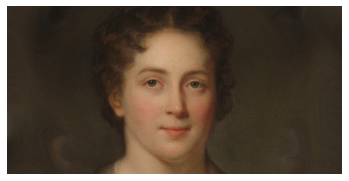

1


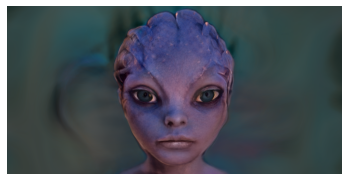

2


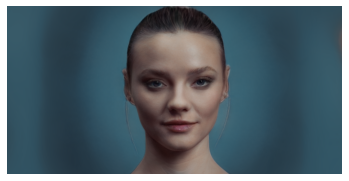

3


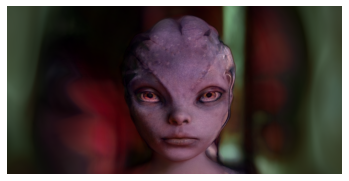

4


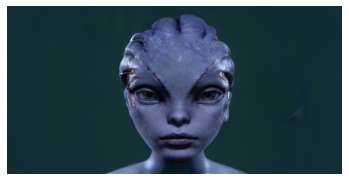

5


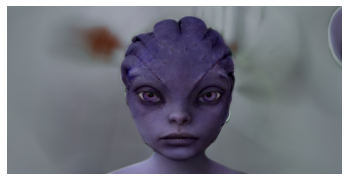

6


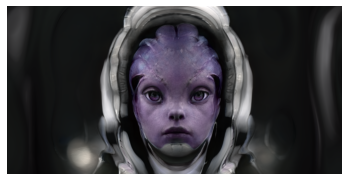

7


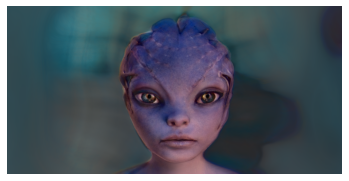

8


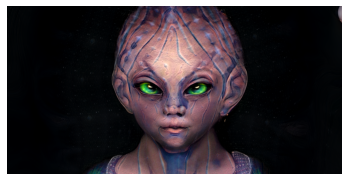

9


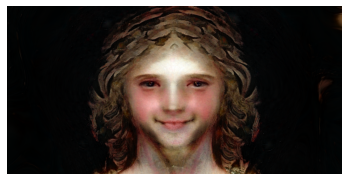

10


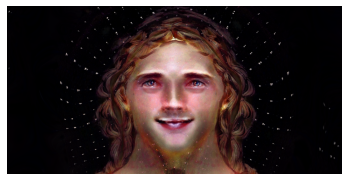

11


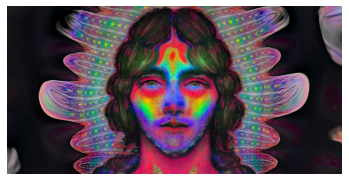

12


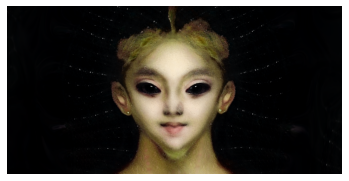

13


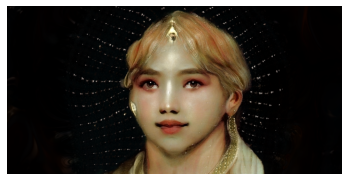

14


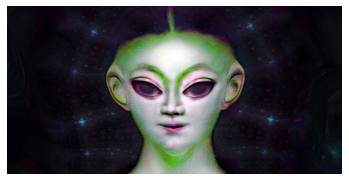

15


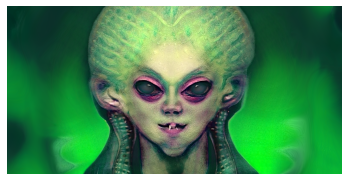

16


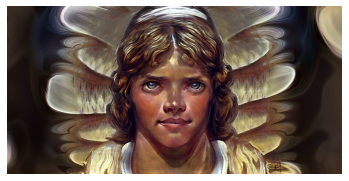

17


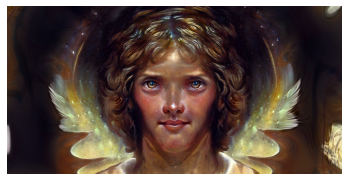

18


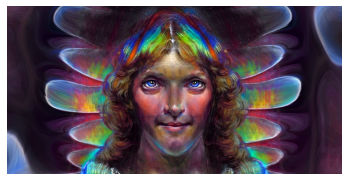

19


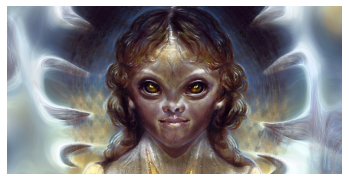

20


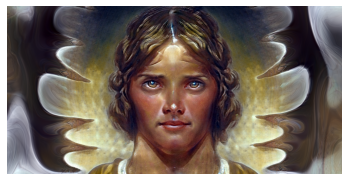

21


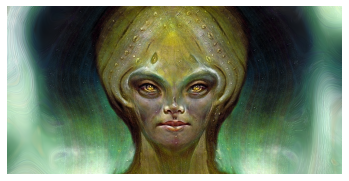

22


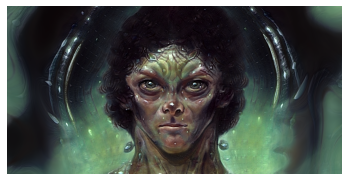

23


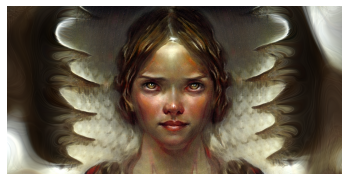

24


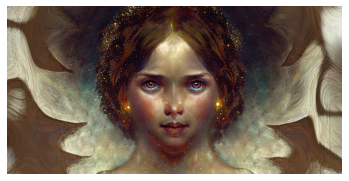

25


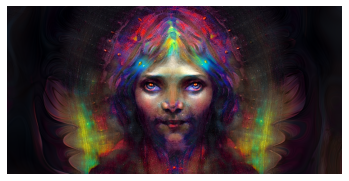

26


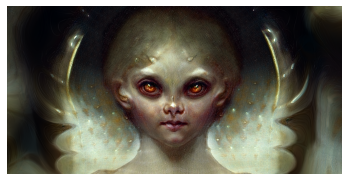

27


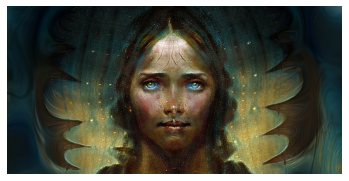

28


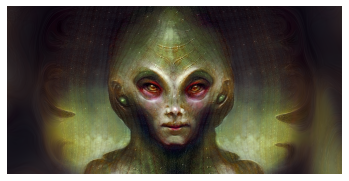

29


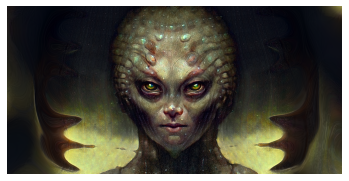

30


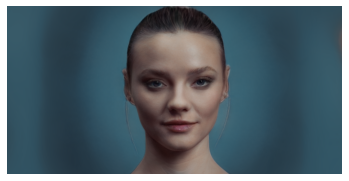

In [21]:
#Image.open(female_angel_paths[-6])
for i in range(len(keyframes)):
    print(i)
    show_latent(imagine, keyframes[i])

In [ ]:
clean = False

if clean:
    remove_idcs = [0, 6, 17, 20, 27, 30, 35, 36, 45, 48, 49, 58, 62, 63, 64, 67, 69, 71, 72, 73, 74, 80, 82, 83]
    keep_idcs = [idx for idx in range(len(keyframes)) if idx not in remove_idcs]
    nice_keyframes = [keyframes[i] for i in keep_idcs]

In [ ]:
#for i in range(len(nice_keyframes)):
#    print(i)
#    show_latent(imagine, nice_keyframes[i])

In [ ]:

if clean:
    model = [1, 61, 62]
    joni = [0, 2, 3, 4, 5]
    different_joni = [6, 7]
    angels = list(range(8, 61))

    deliver_keyframes = []
    # joni to angels
    for i in range(10):
        rand_joni = np.random.choice(joni, 1)[0]
        rand_angel = np.random.choice(angels, 1)[0]
        deliver_keyframes.append(rand_joni)
        deliver_keyframes.append(rand_angel)
    # joni to angel to girl
    for i in range(10):
        rand_joni = np.random.choice(joni, 1)[0]
        rand_angel = np.random.choice(angels, 1)[0]
        model = 1
        deliver_keyframes.append(rand_joni)
        deliver_keyframes.append(rand_angel)
        deliver_keyframes.append(model)
    # alien to model to angels
    for i in range(10):
        rand_joni = np.random.choice(joni, 1)[0]
        rand_angels = np.random.choice(angels, 3, replace=False)
        model = 1
        deliver_keyframes.append(rand_joni)
        deliver_keyframes.append(model)
        for rand_angel in rand_angels:
            deliver_keyframes.append(rand_angel)

    # rest of angels
    deliver_keyframes.append(different_joni[0])
    deliver_keyframes.append(different_joni[1])
    deliver_keyframes.extend(angels)



    #print(deliver_keyframes)
    old_keyframes = keyframes
    #keyframes = [nice_keyframes[i].clone() for i in deliver_keyframes]

In [ ]:
import numpy as np
import scipy

def slerp(low, high, val):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    epsilon = 1e-7
    omega = (low_norm * high_norm).sum(1)
    omega = torch.acos(torch.clamp(omega, -1 + epsilon, 1 - epsilon))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res


def interpolate(ws, wraps=2, w_frames=120, kind='cubic', use_slerp=False):
    if use_slerp:
        last_latent = ws[0] # go back to start at the end
        frames = []
        for i, latent in enumerate(ws):
            next_latent = ws[i + 1] if i + 1 < len(ws) else last_latent
            for w_frame in range(w_frames):
                slerped_latent = slerp(latent, next_latent, w_frame / w_frames)
                frames.append(slerped_latent)
    else:
        # prepare interpolation
        num_keyframes = ws.shape[0]
        x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
        ws = ws.reshape(num_keyframes, *ws.shape[1:])
        y = np.tile(ws.cpu().numpy(), [wraps * 2 + 1, 1, 1])
        interp = scipy.interpolate.interp1d(x, y, kind=kind, axis=0)
        # do interpolation
        frames = []
        for frame_idx in range(num_keyframes * w_frames):
            w = torch.from_numpy(interp(frame_idx / w_frames))
            frames.append(w)
    return frames

In [ ]:
#show_latent(imagine, keyframes[-1])

In [ ]:
import torch

use_slerp = False
w_frames = 240

ws = torch.cat([l.to("cpu") for l in keyframes[0:]])
latent_frames = interpolate(ws, use_slerp=use_slerp, w_frames=w_frames)

In [ ]:
import imageio
from tqdm.auto import tqdm

mp4 =f"test_{use_slerp}_{w_frames}.mp4"

video_kwargs = dict()

sg3 = imagine.model.model
G = sg3.model

if sg3.sg3:
    sg3.extend_sizes = 0.5
else:
    sg3.extend_sizes = 0.0


if 1 == 2 and hasattr(G.synthesis, 'input'):
    m = make_affine_transform(m = None,
                          angle = 0.0,
                          translate_x = 0.0,
                          translate_y = 0.3,
                          scale_x = 1.0,
                          scale_y = 1.0,
                          shear_x = 0.0,
                          shear_y = 0.0,
                          mirror_x = False,
                          mirror_y = False)
    m = np.linalg.inv(m)
    G.synthesis.input.transform.copy_(torch.from_numpy(m))

@torch.inference_mode()
def make_vid(mp4, frames, sg3):
    frames = torch.stack(frames).to(imagine.device)
    with imageio.get_writer(mp4, mode='I', fps=60, codec='libx264', **video_kwargs) as video_out:
        for latent in tqdm(frames):
            sg3 = imagine.model.model
            img = sg3(latents=latent.unsqueeze(0))
            np_img = np.array(to_pil(img.cpu().squeeze(0)))
            video_out.append_data(np_img)

make_vid(mp4, latent_frames, imagine)

In [ ]:
from IPython.display import Video

Video(mp4)